In [1]:
# import basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio

# The Analysis of the Model Output

Only few days a left for this competition. it is time to __finetune__ the models! One of the ways to finetune a model is to analyze the predictions made by this model.

In this notebook I used a csv file, which contains masks predicted by my model for the images from the train set (in `submission.csv` format). I created several helper functions, which you may use to analyze your predictions.

## Load Data and Setup

Setup path to the training set and load the dataframes with labels and predictions:

In [2]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

# load dataframe with train labels
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')

# load my predictions
results_df = pd.read_csv('../input/steelsubmission/test_masks.csv')

In [3]:
train_df.head(3)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN


In [4]:
results_df.head(3)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,76648 4 76891 22 77143 30 77397 36 77651 43 77...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN


Preprocess the dataframes (add dedicated columns for Image filename and Label):

In [5]:
def preprocess_df(df):
    '''
    Function for train dataframe preprocessing.
    Creates additional columns 'Image' with image filename and 'Label' with label number.
    '''
    # split column
    split_df = df["ImageId_ClassId"].str.split("_", n = 1, expand = True)
    new_df = df.copy()

    # add new columns to train_df
    new_df['Image'] = split_df[0]
    new_df['Label'] = split_df[1]

    # check the result
    return new_df

In [6]:
train_df = preprocess_df(train_df)
results_df = preprocess_df(results_df)

Setup the utilities:

In [7]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle=='')|(rle=='-1'): 
        return np.zeros((256,1600) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )

In [8]:
def compute_iou(target, prediction):
    '''
    Function to compute IOU metric
    See:
    https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    '''
    target = np.asarray(target, dtype=float)
    prediction = np.asarray(prediction, dtype=float)
    
    smooth = 1e-5 # smoothing for empty masks
    
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / (np.sum(union) + smooth)
    
    return iou_score

## Visualize Predictions:

`1.` A generic function to compare true and predicted masks for each defect:

In [9]:
def plot_mask(image_filename):
    '''
    Function to plot an image and true/predicted segmentation masks.
    INPUT:
        image_filename - filename of the image (with full path)
    '''
    img_id = image_filename.split('/')[-1]
    image = Image.open(image_filename)
    train = train_df.fillna('-1')
    pred = results_df.fillna('-1')
    
    rle_masks = train[(train['Image'] == img_id)]['EncodedPixels'].values    
    pred_masks = pred[(pred['Image'] == img_id)]['EncodedPixels'].values
    
    fig, axs = plt.subplots(4, 2, figsize=(20, 7))
    
    iou = 0
    for defect in range(1,5):
        rle_mask = rle_masks[defect - 1]
        pred_mask = pred_masks[defect - 1]
        np_mask = 0
        np_mask_pred = 0
        
        if rle_mask != '-1':
            np_mask = rle2maskResize(rle_mask)
            axs[defect - 1, 0].imshow(image)
            axs[defect - 1, 0].imshow(np_mask, alpha = 0.5, cmap = "Reds")
            axs[defect - 1, 0].axis('off')
            axs[defect - 1, 0].set_title('Mask with defect #{}'.format(defect))
        else:
            axs[defect - 1, 0].imshow(image)
            axs[defect - 1, 0].axis('off')
            axs[defect - 1, 0].set_title('No defects type #{}'.format(defect))
            
        if pred_mask != '-1':
            np_mask_pred = rle2maskResize(pred_mask)
            axs[defect - 1, 1].imshow(image)
            axs[defect - 1, 1].imshow(np_mask_pred, alpha = 0.5, cmap = "Reds")
            axs[defect - 1, 1].axis('off')
            axs[defect - 1, 1].set_title('Prediction for mask with defect #{}'.format(defect))
        else:
            axs[defect - 1, 1].imshow(image)
            axs[defect - 1, 1].axis('off')
            axs[defect - 1, 1].set_title('No prediction for defects type #{}'.format(defect))

        # calculate average IOU for all defects
        iou += compute_iou(np_mask, np_mask_pred)
        
    plt.suptitle('IOU for image: {:.2f}'.format(iou), fontsize = 16)
        
    plt.show()

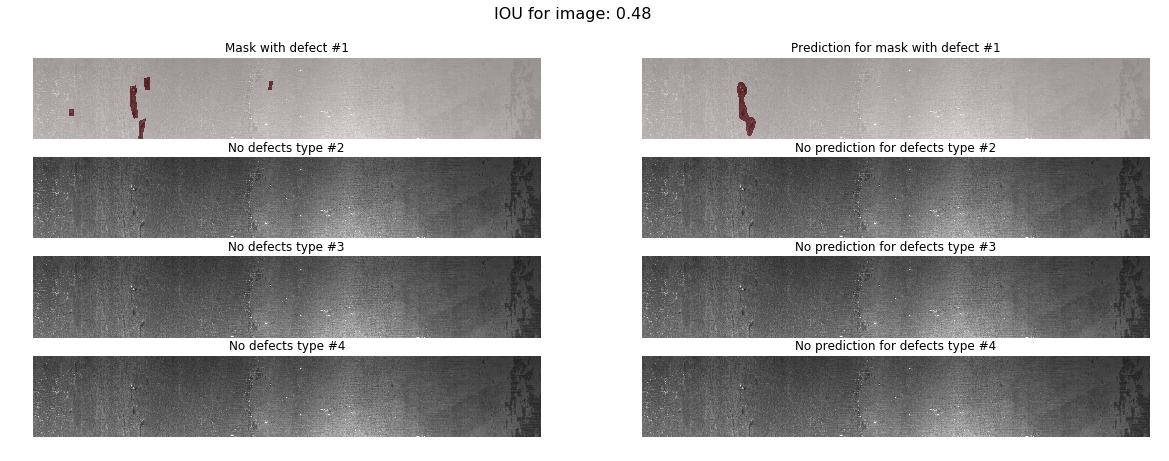

In [10]:
plot_mask(TRAIN_PATH + '0002cc93b.jpg')

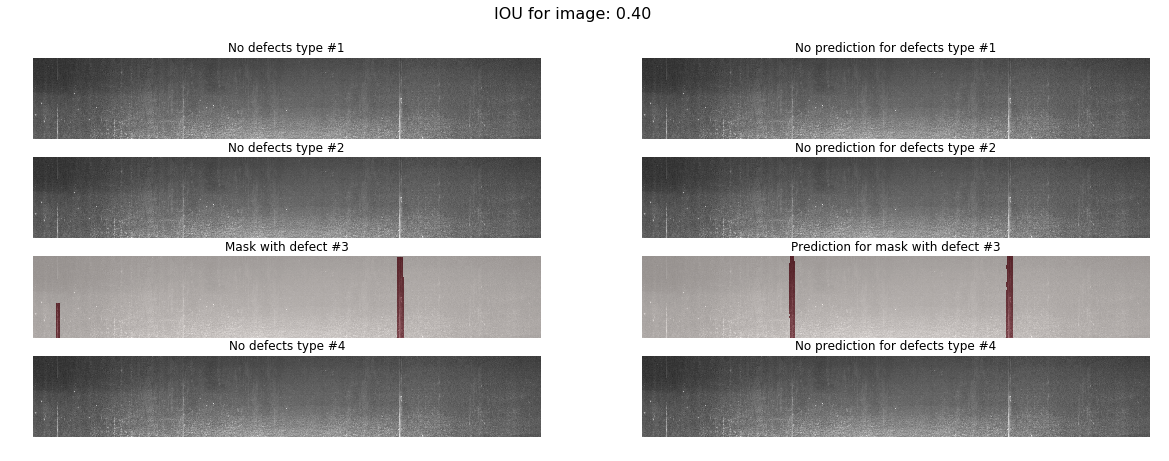

In [11]:
plot_mask(TRAIN_PATH + '0007a71bf.jpg')

Visualizations above tell me that the thresholds for the defects should be tuned (I created my submission with a standard threshold equal to 0.5): the model doesn't identify the minor defects of different types.

`2.` Plot true and predicted mask just by row index:

In [12]:
def plot_mask_by_id(idx):
    '''
    Plots true mask and predicted mask by id in train_df
    '''
    image_name = train_df.iloc[idx]['Image']
    image_filename = TRAIN_PATH + image_name
    image = Image.open(image_filename)
    
    rle_mask = train_df.iloc[idx]['EncodedPixels']
    pred_mask = results_df.iloc[idx]['EncodedPixels']
    
    defect = train_df.iloc[idx]['Label']
    
    true = rle2maskResize(rle_mask)
    pred = rle2maskResize(pred_mask)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 3.5))
    
    iou = compute_iou(true, pred)
    
    axs[0].imshow(image)
    axs[0].imshow(true, alpha = 0.5, cmap = "Reds")
    axs[0].axis('off')
    axs[0].set_title('Mask with defect #{}'.format(defect))
    
    axs[1].imshow(image)
    axs[1].imshow(pred, alpha = 0.5, cmap = "Reds")
    axs[1].axis('off')
    axs[1].set_title('Predicted mask for defect #{}'.format(defect))
    
    plt.suptitle('IOU for image: {:.2f}'.format(iou), fontsize = 16)
    
    plt.show()

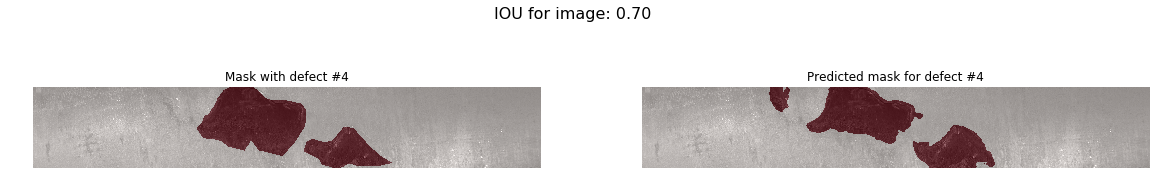

In [13]:
plot_mask_by_id(27)

This prediction is not that bad: the IOU is 0.7! But model still didn't catch a minor defect. Threshold for this type of defect certainly needs to be tuned.

`3.` Plot predicted masks for cases with many masks on single image:

In [14]:
from scipy.ndimage import label, generate_binary_structure

def get_mask(line_id):
    '''
    Function to visualize the image and the mask.
    INPUT:
        line_id - id of the line to visualize the masks
    RETURNS:
        np_mask - numpy segmentation map
    '''
    
    # convert rle to mask
    rle = train_df.loc[line_id]['EncodedPixels']
    
    np_mask = rle2maskResize(rle)
    np_mask = np.clip(np_mask, 0, 1)
        
    return np_mask

def add_mask_areas(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['Area'] = 0
        
    for i, row in masks_df.iterrows():
        masks_df['Area'].loc[i] = np.sum(get_mask(i))
    
    return masks_df

def add_mask_number(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['NumMasks'] = 0
    
    s = generate_binary_structure(2,2)
        
    for i, row in masks_df.iterrows():
        mask = get_mask(i)
        
        if np.sum(mask) > 0:
            labeled_array, labels = label(mask, structure=s)
            masks_df['NumMasks'].loc[i] = labels
        else:
            masks_df['NumMasks'].loc[i] = 0
    
    return masks_df

In [15]:
masks_df = add_mask_number(train_df)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
many_masks_df = masks_df[masks_df['NumMasks'] > 10]
line_ids = many_masks_df.index.values

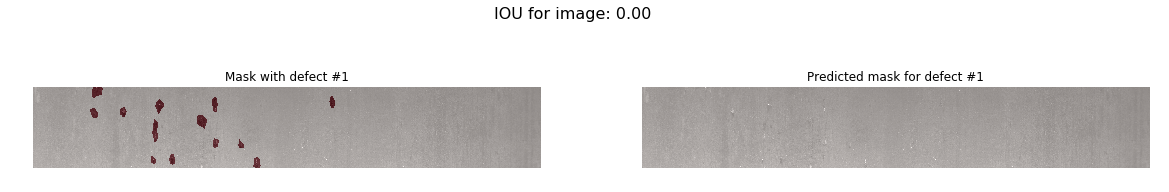

In [17]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

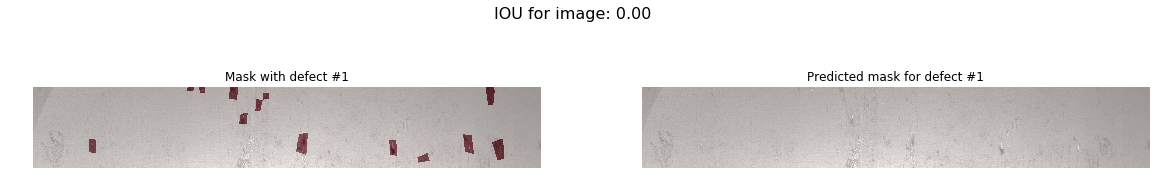

In [18]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

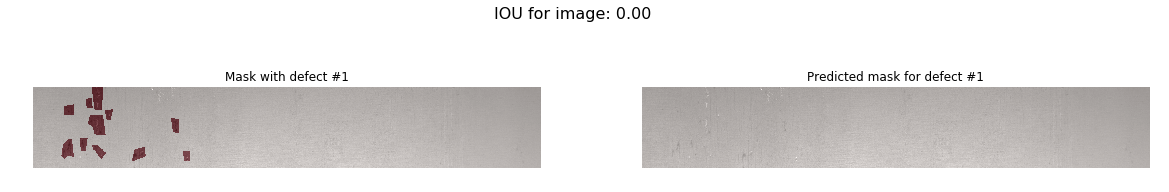

In [19]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

`3.` Plot predicted masks for cases with a large mask:

In [20]:
masks_df = add_mask_areas(masks_df)

In [21]:
# filter the dataframe, so we have only images with very large masks
large_masks_df = masks_df[masks_df['Area'] > 200000]
line_ids = large_masks_df.index.values

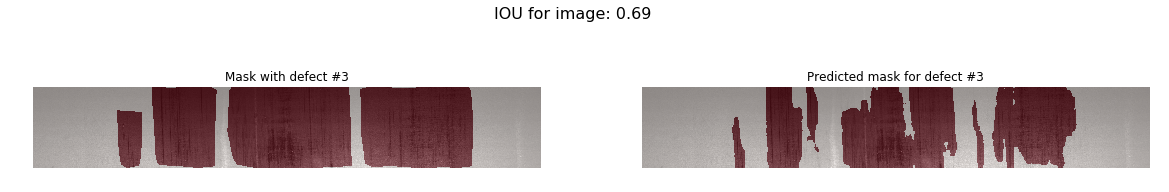

In [22]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

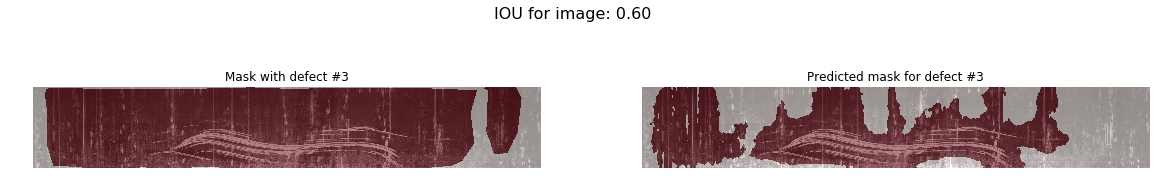

In [23]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

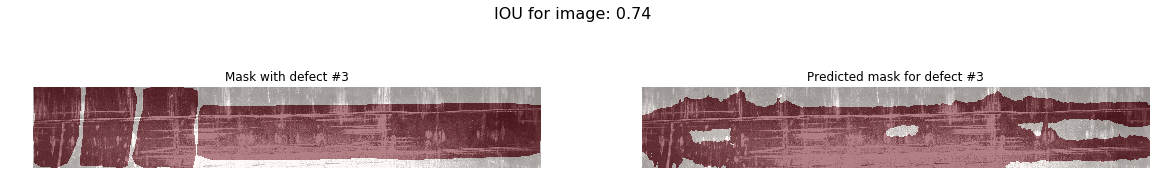

In [24]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

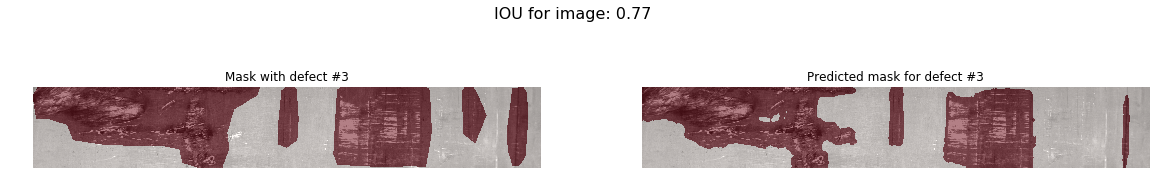

In [25]:
rnd_idx = line_ids[np.random.randint(len(line_ids))]
plot_mask_by_id(rnd_idx)

To my mind, the ground truth itself is controversial for large masks: somewhere the defects are cropped out accurately, somewhere there is a lot of empty space between the defects. That is why it is hard to achieve good performance on such images.

## Conclusion

The visualization of predicted masks can tell a lot. In my case, it tells me that my model certainly fails to find small defects of different types. The most probably, I should tune the thresholds or add some morphological postprocessing of the resulting masks.

## References:
1. Kernel with [function to convert RLE to mask](https://www.kaggle.com/titericz/building-and-visualizing-masks)
2. Article with [calculation of IOU](https://www.jeremyjordan.me/evaluating-image-segmentation-models/)